# Modelling of Atmospheric Clodus
#### copyright: Jagiellonian University   
#### licence: CC-BY
#### author: Sylwester Arabas

## Class 5 (March 23, virtual)

Let's try to reproduce Figure 7.4 from Rogers & Yau 
(first and last panel last week, middle panels this week)

![alt text](Rogers_Yau_Fig_7.4.png "Rogers_Yau_Fig_7.4")

### previously on...

In [1]:
import numpy as np
import pint
from matplotlib import pyplot, rcParams
# <NEW>
rcParams['figure.figsize'] = [14, 5]
# </NEW>
si = pint.UnitRegistry()
si.setup_matplotlib()

In [2]:
class Constants:
    from scipy import constants
    import mendeleev as pt
    
    # polynomial fot to equilibrium vapour pressure wrt water (coefficients from Flatau et al. 1992)
    # doi:10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2
    c_w = (6.115836990e000, 0.444606896e000, 0.143177157e-01, 0.264224321e-03, 0.299291081e-05,
           0.203154182e-07, 0.702620698e-10, 0.379534310e-13, -.321582393e-15)
    
    T0 = T0 = constants.zero_Celsius * si.kelvin
    
    def __molar_mass(x):
        return x.atomic_weight * si.gram / si.mole

    M_a = (
        0.78 * __molar_mass(pt.N) * 2 + 
        0.21 * __molar_mass(pt.O) * 2 + 
        0.01 * __molar_mass(pt.Ar)
    )
    M_v = __molar_mass(pt.O) + __molar_mass(pt.H) * 2
    
    R_str = constants.R * si.joule / si.kelvin / si.mole
    
    R_a = R_str / M_a
    R_v = R_str / M_v
    
    g = constants.g * si.metre / si.second**2
    
    l_v = 2.5e6 * si.joule / si.kilogram
    c_p  = 1000 * si.joule / si.kilogram / si.kelvin
    
    # <NEW>
    D = 2.26e-5 * si.metre ** 2 / si.second
    rho_w = 1 * si.kilogram / si.litre
    # </NEW>

In [3]:
class Formulae:
    @staticmethod
    def rho(p, R, T):
        return p / (R * T)

    @staticmethod
    def __p_sat(temperature, coefficients, valid_range):
        from numpy.polynomial.polynomial import polyval

        value = polyval(temperature.to(si.celsius).magnitude, coefficients)

        if isinstance(temperature.magnitude, np.ndarray):
            value[np.logical_or(temperature < valid_range[0], temperature > valid_range[1])] = np.nan
        else:
            value = np.nan if not valid_range[0] < temperature <= valid_range[1] else value

        return value * si.hectopascals    

    @staticmethod
    def p_eq(T):
        return Formulae.__p_sat(T, Constants.c_w, (Constants.T0-85 * si.kelvin, np.inf * si.kelvin))
    
    # <NEW>
    @staticmethod
    def lognormal(r, n_tot, r_m, gstdev):
        return n_tot / r \
          * np.exp(-pow((np.log(r/r_m)), 2)/2 / pow(np.log(gstdev),2)) \
          / np.log(gstdev) \
          / np.sqrt(2*np.pi)
    # </NEW>

In [4]:
class Storage:
    class __Impl(np.ndarray):
        p_idx, p_unit = 0, si.hectopascals
        T_idx, T_unit = 1, si.kelvins
        m_unit = si.grams
        z_unit = si.metres
        
        # <NEW>
        @property
        def m_idx(self):
            return slice(2, self.shape[0])
        # </NEW>
        
        @property
        def p(self):
            return self[self.p_idx] * self.p_unit

        @p.setter
        def p(self, value):
            self[self.p_idx] = (value.to(self.p_unit) / self.p_unit).magnitude

        @property
        def T(self):
            return self[self.T_idx] * self.T_unit

        @T.setter
        def T(self, value):
            self[self.T_idx] = (value.to(self.T_unit) / self.T_unit).magnitude

        @property
        def m(self):
            return self[self.m_idx] * self.m_unit

        @m.setter
        def m(self, value):
            self[self.m_idx] = (value.to(self.m_unit) / self.m_unit).magnitude

    @staticmethod
    def __make_storage(shape):
        storage = Storage.__Impl(shape)
        return storage
    
    # <NEW>
    @staticmethod
    def make_state(n_particles):
        return Storage.__make_storage((2 + n_particles,))
    #</NEW>
    
    @staticmethod
    def make_deriv(state):
        storage = Storage.__make_storage(state.shape)
        storage.p_unit /= storage.z_unit
        storage.T_unit /= storage.z_unit
        storage.m_unit /= storage.z_unit
        return storage
    
    @staticmethod
    def view_state(array):
        storage = Storage.__make_storage(array.shape)
        storage[:] = array[:]
        return storage

### the new ODE system we will solve ...

<center><b>last week (bulk):</b></center>
$$
\begin{eqnarray}
  \frac{dp}{dz} &=& - \rho g \\
  \frac{dm}{dz} &=& \frac{\max(0, m_v - m_{eq})}{dz} \\
  \frac{dT}{dz} &=& \frac{1}{c_p} \left(\frac{1}{\rho}\frac{dp}{dz} + \frac{l_v}{m_a} \frac{dm}{dz} \right)
\end{eqnarray}
$$
$$$$
<center><b>this week (particles):</b></center>
$$
\begin{eqnarray}
  \frac{dp}{dz} &=& - \rho g \\
  \frac{dm_i}{dz} &=& \frac{\xi_i}{w} \max\!\!\left[0,\,\,\frac{4\pi r_i^2}{r_i} D (\rho_v - \rho_{eq})\right]\\ &=& \frac{\xi_i}{w}\max\!\!\left[0,\,\,(4 \pi)^{2/3} \sqrt[3]{\frac{3m_i}{\xi_i\rho_w}}\,D \left(\rho_v - \frac{p_{eq}(T)}{R_v T}\right)\right]\\
  \vdots\\
  \frac{dT}{dz} &=& \frac{1}{c_p} \left(\frac{1}{\rho}\frac{dp}{dz} + \frac{l_v}{m_a} \sum_i \frac{dm_i}{dz} \right)
\end{eqnarray}
$$

$p$: pressure   
$z$: vertical displacement   
$\rho$: air density   
$g$: gravitational acceleration   
$r_i$: radius of size category $i$
$m_i$: mass of liquid water in size category $i$ (i.e., sum of masses of particles of radius $r_i$)   
$\xi_i$: multiplicity of size category $i$ (i.e., number of particles of radius $r_i$)      
$\rho_v$: density of water vapour
$\rho_{eq}$: density of water vapour at saturation (in phase equilibrium wrt water surface)   
$T$: temperature   
$c_p$: specific heat of air   
$l_v$: latent heat of vapourisation   
$m_a$: mass of air

### ... implemented according to SciPy API

In [5]:
class System:
    def __init__(self, pv0, volume, w, xi, state):
        self.m_a = Formulae.rho(state.p, Constants.R_a, state.T) * volume
        self.m_w = Formulae.rho(pv0, Constants.R_v, state.T) * volume \
                 + np.sum(state.m) 
        self.w = w
        self.xi = xi
        
    def __call__(self, _, state):
        state = Storage.view_state(state)
        deriv = Storage.make_deriv(state)
            
        rho = Formulae.rho(state.p, Constants.R_a, state.T)
        volume = self.m_a / rho
        rho_eq = Formulae.p_eq(state.T) / Constants.R_v / state.T
        rho_v = (self.m_w - np.sum(state.m)) / volume
                        
        # hydrostatic pressure
        deriv.p = -Formulae.rho(state.p, Constants.R_a, state.T) * Constants.g
        
        # Fick's law
        deriv.m = self.xi / self.w * (4*np.pi)**(2/3) * (3*state.m/self.xi/Constants.rho_w)**(1/3) \
            * Constants.D * (rho_v - rho_eq)
        deriv.m = (deriv.m + np.abs(deriv.m)) / 2
            
        # heat budget
        deriv.T = (deriv.p/rho + np.sum(deriv.m)/self.m_a * Constants.l_v) / Constants.c_p
                            
        return deriv

### instead of a simplest ODE solver (last week), let's now use a more sophisticated one from SciPy

In [6]:
from scipy import integrate
def solve(system, state, displacement):
    integ = integrate.solve_ivp(
        system, 
        [0, displacement / state.z_unit], 
        state,
        max_step=(.1 * si.metre / state.z_unit).magnitude
    )
    assert integ.success, integ.message
    return Storage.view_state(integ.y), integ.t * state.z_unit

### and let's finally do the calculations ...

In [7]:
n_particles = 64
volume = 1 * si.metre**3
T0 = 300 * si.kelvins
p0 = 1000 * si.hectopascals 
pv0 = .995 * Formulae.p_eq(T0)
displacement = 100 * si.metres

radii, dr = np.linspace(200, 3000, n_particles, retstep=True) * si.nanometre
n_n = Formulae.lognormal(r=radii, n_tot=50/si.centimetre**3, r_m = 1*si.micrometre, gstdev=1.3)
xi = n_n * dr * volume

systems = {}
solutions = {}
zsteps = {}
for w in [.5, 2] * si.metre / si.second:
    state = Storage.make_state(n_particles)
    state.p = p0
    state.T = T0
    state.m = 4/3 * np.pi * Constants.rho_w * xi * radii**3
                
    systems[w] = System(pv0, volume, w, xi, state)
    solutions[w], zsteps[w] = solve(systems[w], state, displacement)

### ... and plotting

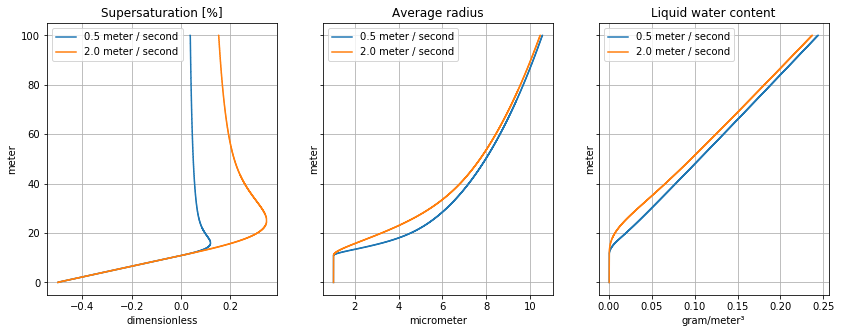

In [8]:
fig, axs = pyplot.subplots(1, 3, sharey=True)

for w in solutions.keys():
    sys = systems[w]
    sol = solutions[w]
    z = zsteps[w]

    m_v = sys.m_w - np.sum(sol.m, axis=0)
    volume = sys.m_a / Formulae.rho(sol.p, Constants.R_a, sol.T) 
    p_v = m_v / volume * Constants.R_v * sol.T
    p_eq = Formulae.p_eq(sol.T)

    axs[0].step(100 * (p_v / p_eq - 1), z, label=w)
    
    xi_2d = xi.reshape(-1,1).repeat(z.shape[0], axis=1)
    mult = 3/4/np.pi/Constants.rho_w
    rads = (sol.m / xi_2d * mult)**(1/3)
    mean_r = np.sum(rads * xi_2d, axis=0) / np.sum(xi)
    axs[1].step(mean_r, z, label=w)
    axs[1].xaxis.set_units(si.micrometres)
    
    axs[2].step((sys.m_w - m_v) / volume, z, label=w)
    axs[2].xaxis.set_units(si.grams / si.metre**3)

for i in range(len(axs)): 
    axs[i].legend(loc='upper left')
    axs[i].grid()
    
_ = axs[0].set_title('Supersaturation [%]')
_ = axs[1].set_title('Average radius')
_ = axs[2].set_title('Liquid water content')

## Homework (instead of the lab): plot evolution of the spectra

## Next week: particle collisions & PySDM project ideas

## In two weeks: pitch session! (everyone presents for 5 minutes + 5 min. discussion)